In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

plt.rcParams['figure.figsize'] = (32, 18)

E:\Users\Chance\Anaconda3\envs\info7390\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Context
The Pronto Cycle Share system consists of 500 bikes and 54 stations located in Seattle. Pronto provides open data on individual trips, stations, and daily weather.



### Trip dataset

trip_id: numeric ID of bike trip taken

starttime: day and time trip started, in PST

stoptime: day and time trip ended, in PST

bikeid: ID attached to each bike

tripduration: time of trip in seconds

from_station_name: name of station where trip originated

to_station_name: name of station where trip terminated

from_station_id: ID of station where trip originated

to_station_id: ID of station where trip terminated

usertype: "Short-Term Pass Holder" is a rider who purchased a 24-Hour or 3-Day Pass; "Member" is a rider who purchased a Monthly or an Annual Membership

gender: gender of rider

birthyear: birth year of rider

In [2]:
#dataset from https://www.kaggle.com/pronto/cycle-share-dataset
trip = pd.read_csv("cycle-share-dataset/trip.csv", skiprows=50794, 
                   names = ["trip_id", "starttime", "stoptime", "bikeid","tripduration","from_station_name","to_station_name","from_station_id","to_station_id","usertype","gender","birthyear"])

In [3]:
trip.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


In [4]:
#Time series test
trip['starttime'] = pd.to_datetime(trip['starttime'])

In [5]:
trip.index = trip['starttime']

In [6]:
#bick usage group by day
trip.resample('D').size()
rides = trip.resample('D').size()

In [7]:
weather = pd.read_csv("cycle-share-dataset/weather.csv")
weather.head()

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,...,Mean_Sea_Level_Pressure_In,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Events
0,10/13/2014,71,62.0,54,55,51,46,87,68,46,...,29.79,29.65,10,10,4,13,4,21,0.00,Rain
1,10/14/2014,63,59.0,55,52,51,50,88,78,63,...,29.75,29.54,10,9,3,10,5,17,0.11,Rain
2,10/15/2014,62,58.0,54,53,50,46,87,77,67,...,29.71,29.51,10,9,3,18,7,25,0.45,Rain
3,10/16/2014,71,61.0,52,49,46,42,83,61,36,...,29.95,29.81,10,10,10,9,4,-,0.00,Rain
4,10/17/2014,64,60.0,57,55,51,41,87,72,46,...,29.78,29.73,10,10,6,8,3,-,0.14,Rain


In [8]:
weather.shape

(689, 21)

In [9]:
#Weather time series format 
weather['Date'] = pd.to_datetime(weather['Date'])

In [10]:
weather.index = weather['Date']

In [11]:
weather['rides'] = trip.resample('D').size()

In [12]:
#Just combine ride times and weather table
weather.head()

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,...,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Events,rides
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-13,2014-10-13,71,62.0,54,55,51,46,87,68,46,...,29.65,10,10,4,13,4,21,0.00,Rain,409
2014-10-14,2014-10-14,63,59.0,55,52,51,50,88,78,63,...,29.54,10,9,3,10,5,17,0.11,Rain,491
2014-10-15,2014-10-15,62,58.0,54,53,50,46,87,77,67,...,29.51,10,9,3,18,7,25,0.45,Rain,313
2014-10-16,2014-10-16,71,61.0,52,49,46,42,83,61,36,...,29.81,10,10,10,9,4,-,0.00,Rain,395
2014-10-17,2014-10-17,64,60.0,57,55,51,41,87,72,46,...,29.73,10,10,6,8,3,-,0.14,Rain,294


In [13]:
weather

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,...,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Events,rides
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-13,2014-10-13,71,62.0,54,55,51,46,87,68,46,...,29.65,10,10,4,13,4,21,0.00,Rain,409
2014-10-14,2014-10-14,63,59.0,55,52,51,50,88,78,63,...,29.54,10,9,3,10,5,17,0.11,Rain,491
2014-10-15,2014-10-15,62,58.0,54,53,50,46,87,77,67,...,29.51,10,9,3,18,7,25,0.45,Rain,313
2014-10-16,2014-10-16,71,61.0,52,49,46,42,83,61,36,...,29.81,10,10,10,9,4,-,0.00,Rain,395
2014-10-17,2014-10-17,64,60.0,57,55,51,41,87,72,46,...,29.73,10,10,6,8,3,-,0.14,Rain,294
2014-10-18,2014-10-18,68,64.0,59,59,57,55,90,83,68,...,29.80,10,8,2,10,4,-,0.31,Rain,399
2014-10-19,2014-10-19,73,64.0,55,57,55,53,94,74,52,...,29.67,10,10,6,10,3,18,0.00,NaN,666
2014-10-20,2014-10-20,66,60.0,55,57,54,50,90,78,67,...,29.69,10,10,5,12,5,-,0.44,Rain,389
2014-10-21,2014-10-21,64,58.0,55,52,49,46,87,70,58,...,29.74,10,10,6,15,8,21,0.10,Rain,357


In [14]:
weather.apply(lambda x: sum(x.isnull()),axis=0) 

Date                            0
Max_Temperature_F               0
Mean_Temperature_F              1
Min_TemperatureF                0
Max_Dew_Point_F                 0
MeanDew_Point_F                 0
Min_Dewpoint_F                  0
Max_Humidity                    0
Mean_Humidity                   0
Min_Humidity                    0
Max_Sea_Level_Pressure_In       0
Mean_Sea_Level_Pressure_In      0
Min_Sea_Level_Pressure_In       0
Max_Visibility_Miles            0
Mean_Visibility_Miles           0
Min_Visibility_Miles            0
Max_Wind_Speed_MPH              0
Mean_Wind_Speed_MPH             0
Max_Gust_Speed_MPH            185
Precipitation_In                0
Events                        361
rides                           0
dtype: int64

In [15]:
#correlation between Mean_Temperature_F and ride

In [16]:
weather = weather[pd.notnull(weather['Mean_Temperature_F'])]

In [17]:
# from sklearn import linear_model
X = weather[["Mean_Temperature_F"]]
y = weather[["rides"]]

# Fit the linear model
#model = linear_model.LinearRegression()
model = linear_model.Ridge()
results = model.fit(X, y)

# Print the coefficients
print (results.intercept_, results.coef_)

[-287.51265145] [[ 11.14214498]]


In [18]:
# import statsmodels.api as sm
# Note the swap of X and y
model = sm.OLS(y, X)
results = model.fit()
# Statsmodels gives R-like statistical output
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     6693.
Date:                Mon, 06 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:45:11   Log-Likelihood:                -4239.4
No. Observations:                 688   AIC:                             8481.
Df Residuals:                     687   BIC:                             8485.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Mean_Temperature_F     6.2271      0.076     81.813      0.000       6.078       6.377
==============================================================================
Omnibus:                       33.929   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.292
Skew:                           0.428   Prob(JB):                     5.38e-11
Kurtosis:                       3.957   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
print('Parameters: ', results.params)
print('R2: ', results.rsquared)

Parameters:  Mean_Temperature_F    6.227065
dtype: float64
R2:  0.906914563642


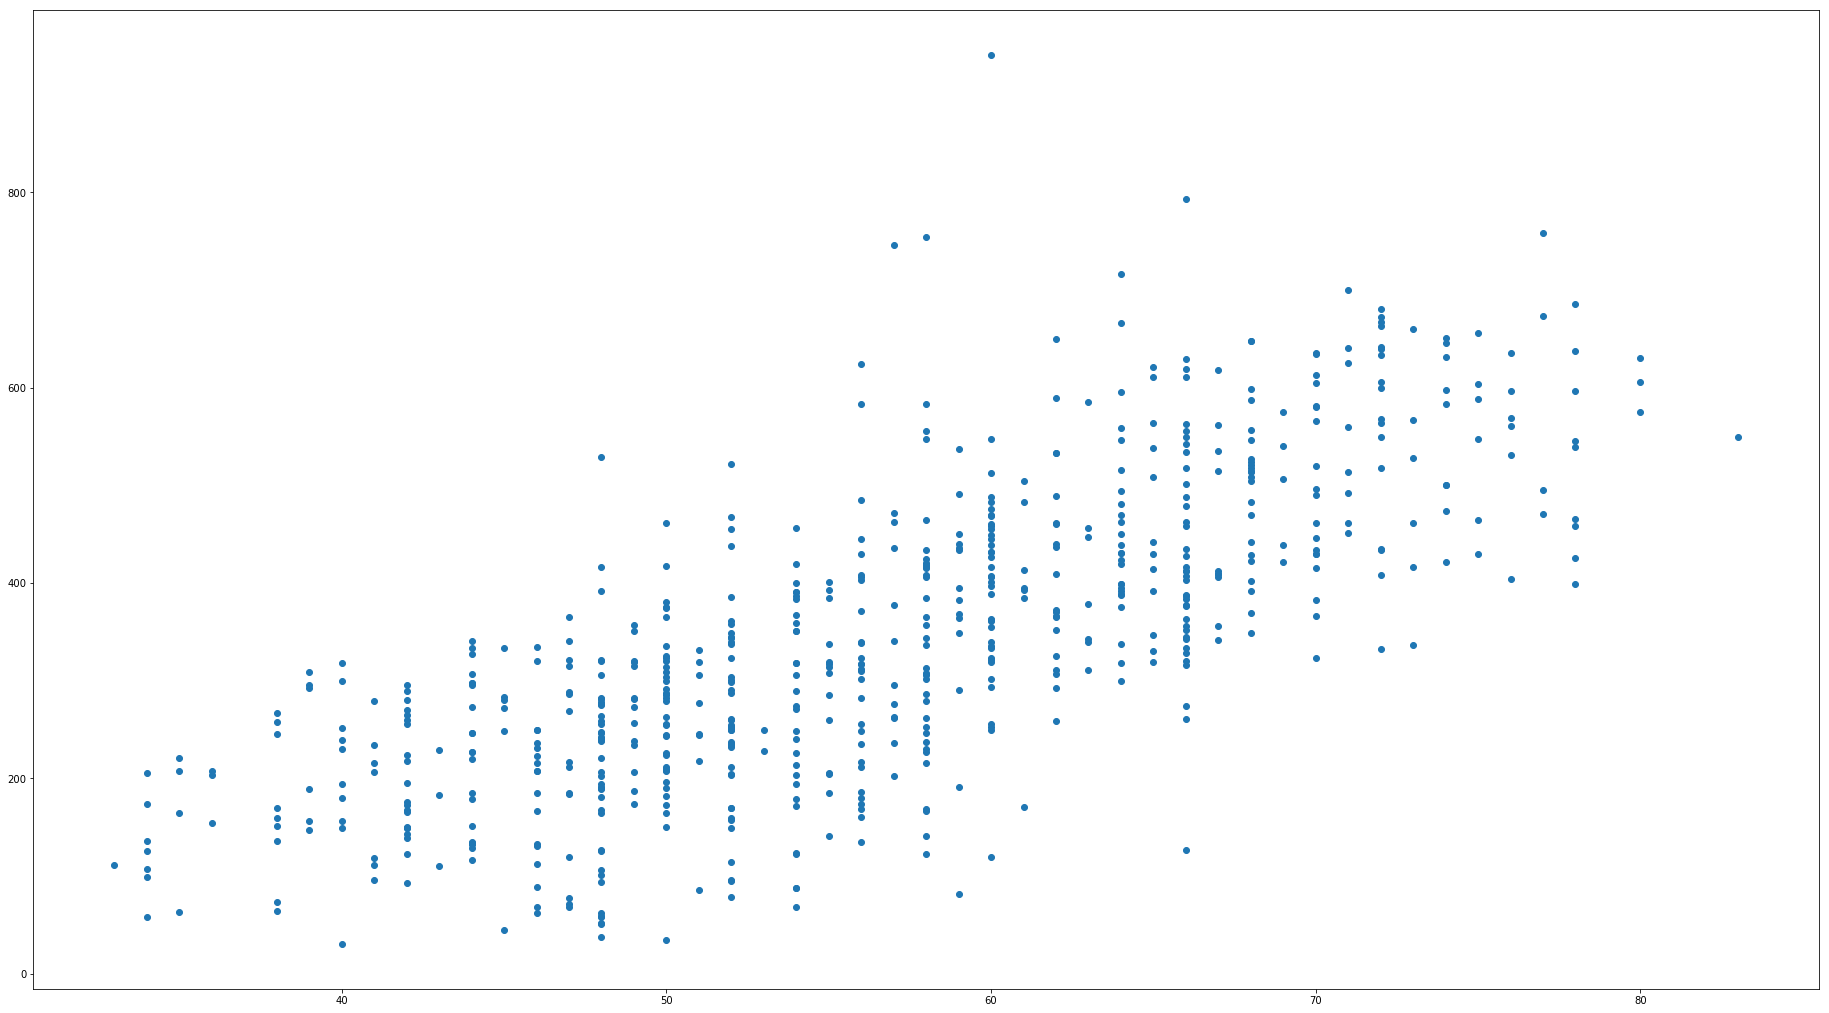

In [20]:
plt.plot(X, y, "o")

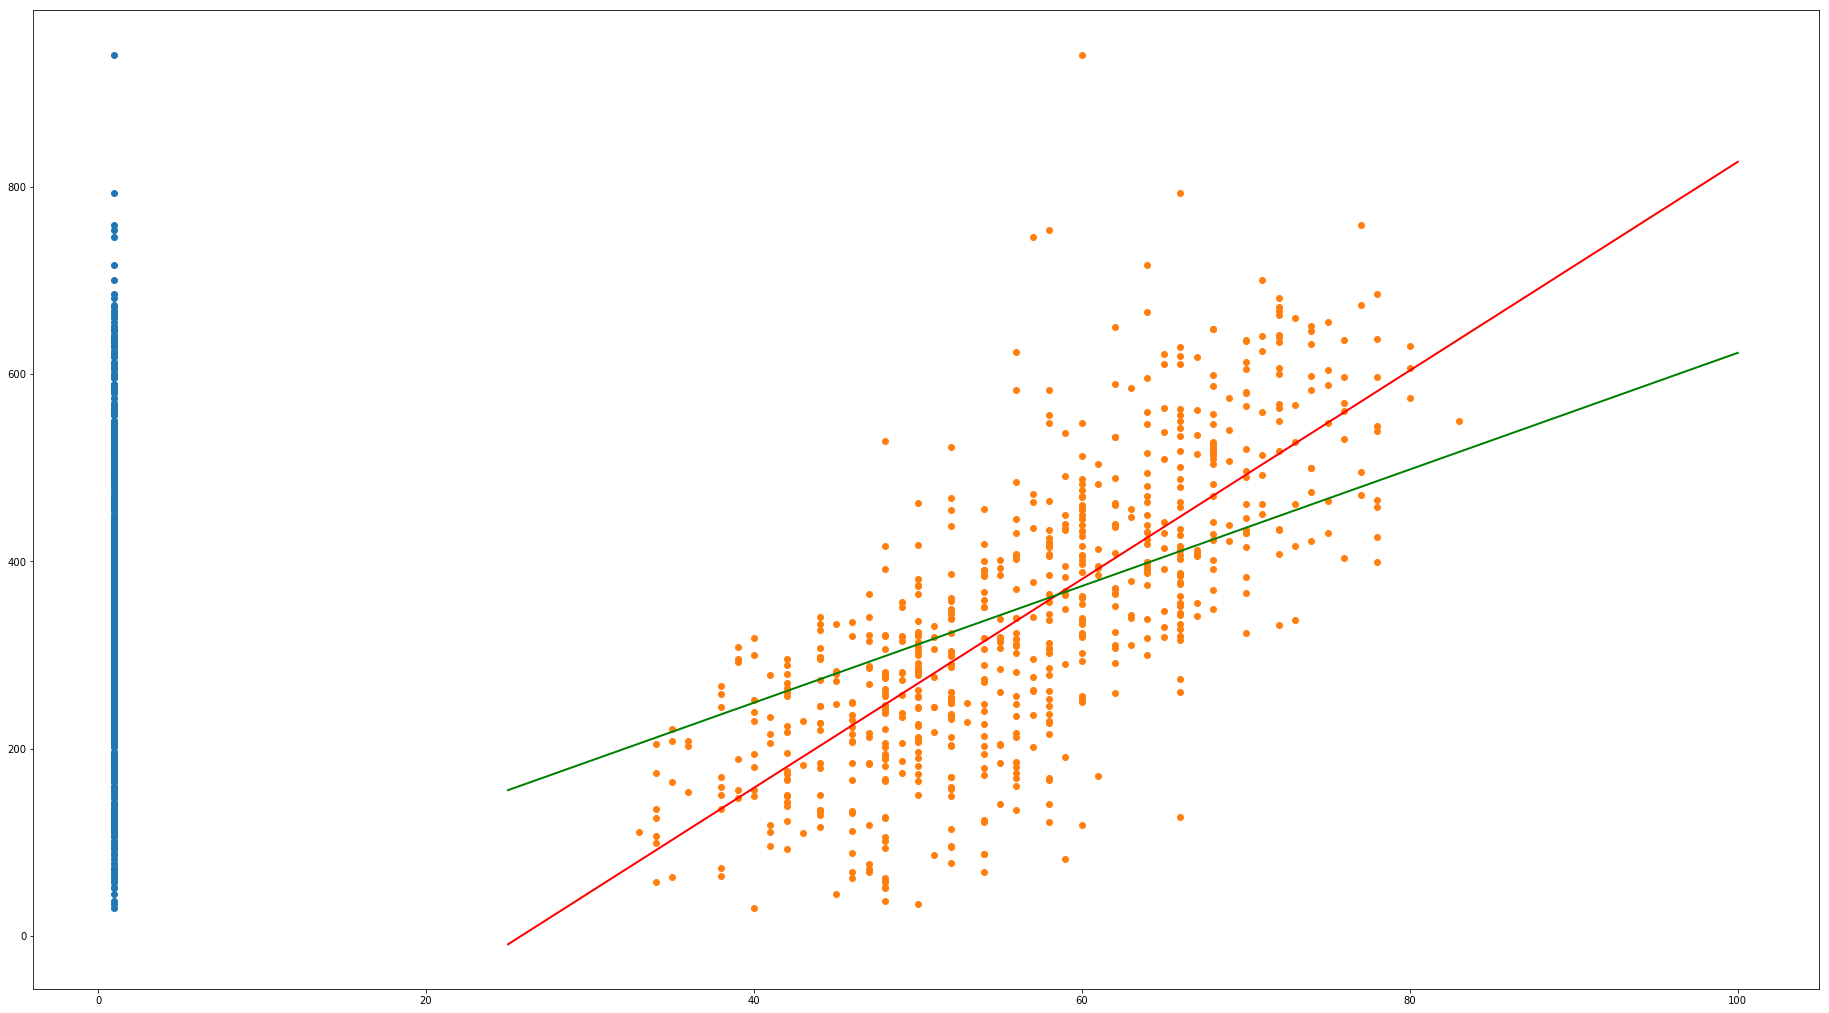

In [21]:
X = sm.add_constant(X) #  Our model needs an intercept so we add a column of 1s:
plt.plot(X, y, "o")
x2 = np.linspace(25, 100, 20)
y2 = -287.52112312 + (11.1422947*x2)
plt.plot(x2, y2, lw=2, color="r")
x2 = np.linspace(25, 100, 20)
y2 = (6.227065*x2)
plt.plot(x2, y2, lw=2, color="g")
plt.show()

In [22]:
print('Parameters:\n', results.params)
print('R2: ', results.rsquared)

Parameters:
 Mean_Temperature_F    6.227065
dtype: float64
R2:  0.906914563642


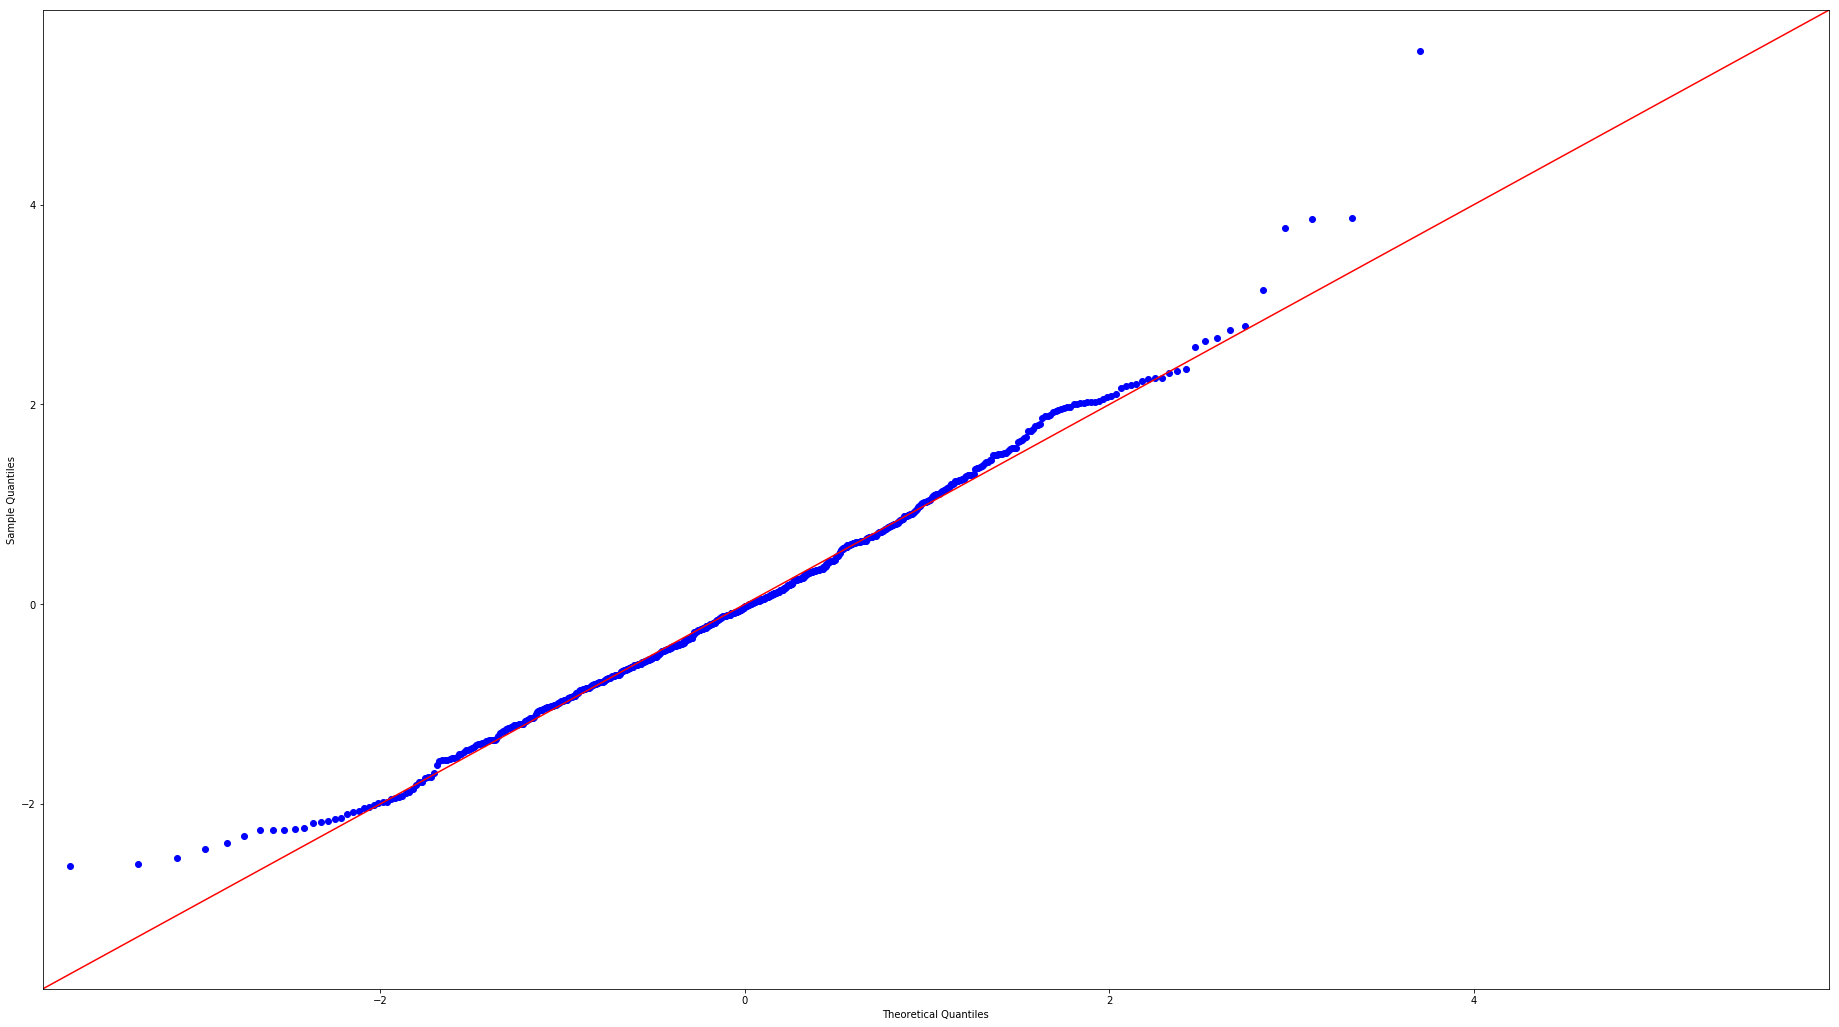

In [23]:
#qq-plotresults
sm.qqplot(results.resid, stats.t, fit=True, line='45')
pylab.show()

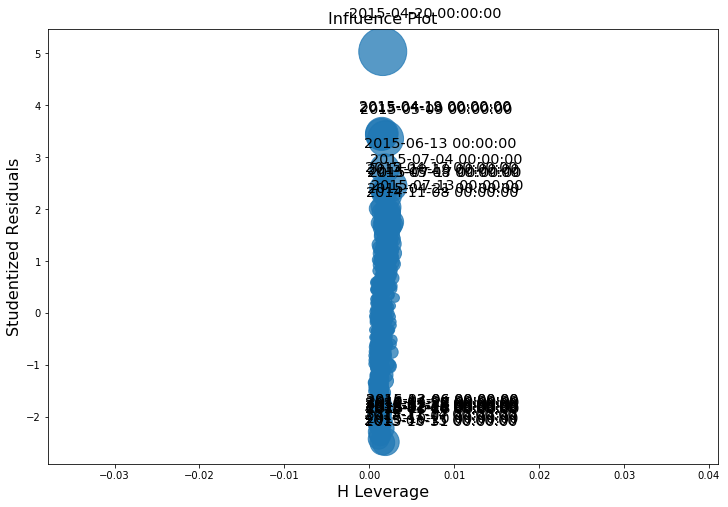

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results, alpha  = 0.05, ax=ax, criterion="cooks")

In [25]:
# from sklearn import linear_model
X = weather[["Mean_Humidity"]]
y = weather[["rides"]]

# Fit the linear model
#model = linear_model.LinearRegression()
model = linear_model.Ridge()
results = model.fit(X, y)

# Print the coefficients
print (results.intercept_, results.coef_)

[ 909.41062134] [[-8.27096304]]


In [26]:
model = sm.OLS(y, X)
results = model.fit()
# Statsmodels gives R-like statistical output
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1723.
Date:                Mon, 06 Nov 2017   Prob (F-statistic):          2.09e-189
Time:                        13:45:13   Log-Likelihood:                -4624.4
No. Observations:                 688   AIC:                             9251.
Df Residuals:                     687   BIC:                             9255.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Mean_Humidity     4.5668      0.110     41.511      0.000       4.351       4.783
==============================================================================
Omnibus:                       21.425   Durbin-Watson:                   0.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.965
Skew:                           0.344   Prob(JB):                     7.62e-05
Kurtosis:                       2.566   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
weather_r_T_H = weather[['Mean_Temperature_F','Mean_Humidity', 'rides']].dropna()

In [28]:
# -1 removes the y intercept
weather_model = ols("rides ~ Mean_Temperature_F + Mean_Humidity -1", data=weather_r_T_H).fit()
weather_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     5273.
Date:                Mon, 06 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:45:13   Log-Likelihood:                -4094.5
No. Observations:                 688   AIC:                             8193.
Df Residuals:                     686   BIC:                             8202.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Mean_Temperature_F     9.7040      0.193     50.155      0.000       9.324      10.084
Mean_Humidity         -3.0301      0.160    -18.961      0.000      -3.344      -2.716
==============================================================================
Omnibus:                       40.793   Durbin-Watson:                   1.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.051
Skew:                           0.346   Prob(JB):                     7.58e-20
Kurtosis:                       4.610   Cond. No.                         6.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

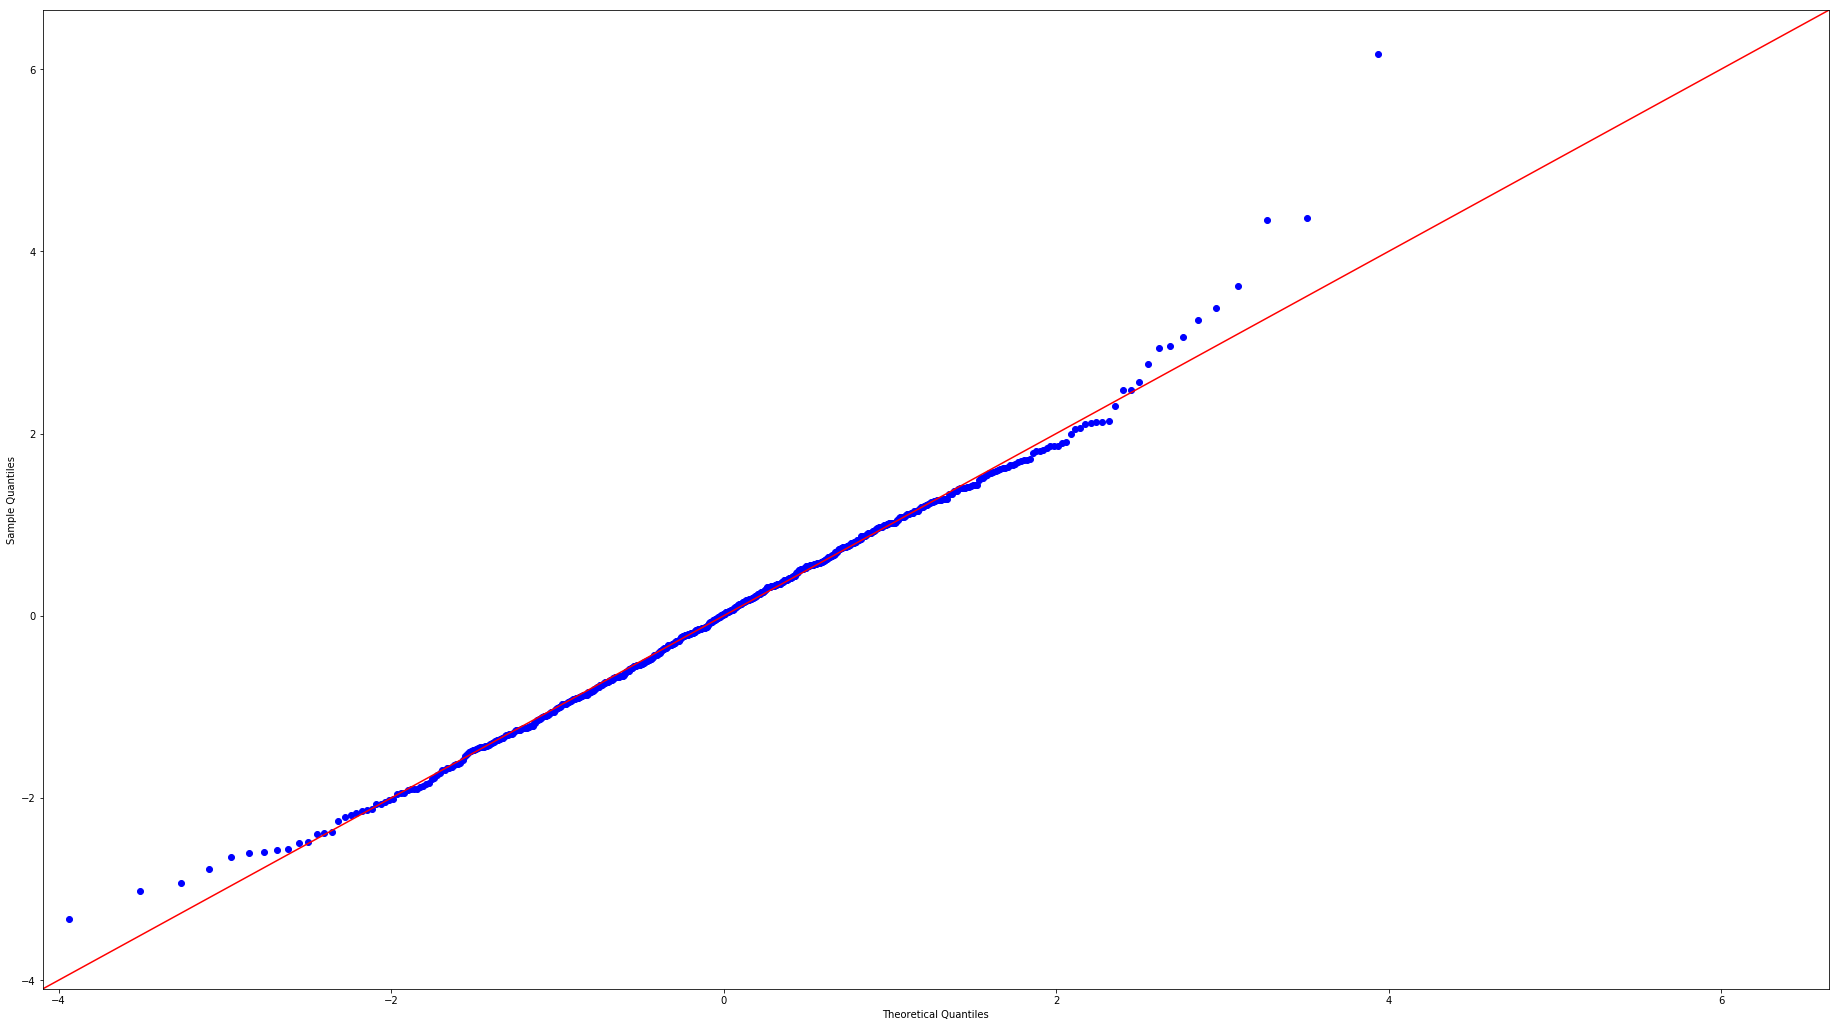

In [29]:
#qq-plotresults
sm.qqplot(weather_model.resid, stats.t, fit=True, line='45')
pylab.show()

In [30]:
weather_r_T_H.corr()

,Mean_Temperature_F,Mean_Humidity,rides
Mean_Temperature_F,1.000000,-0.584973,0.749578
Mean_Humidity,-0.584973,1.000000,-0.678984
rides,0.749578,-0.678984,1.000000


In [31]:
X = weather[["Mean_Temperature_F",'Mean_Humidity']]
y = weather[["rides"]]

In [32]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [33]:
vif.round(1)

,VIF Factor,features
0,9.8,Mean_Temperature_F
1,9.8,Mean_Humidity


In [34]:
weather_r_T_P = weather[['Mean_Temperature_F', 'Precipitation_In', 'rides']].dropna()

In [35]:
weather_model = ols("rides ~ Mean_Temperature_F + Precipitation_In - 1", data=weather_r_T_P).fit()
weather_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     4653.
Date:                Mon, 06 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:45:14   Log-Likelihood:                -4134.7
No. Observations:                 688   AIC:                             8273.
Df Residuals:                     686   BIC:                             8282.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Mean_Temperature_F     6.6328      0.070     94.245      0.000       6.495       6.771
Precipitation_In    -245.1873     15.692    -15.625      0.000    -275.997    -214.378
==============================================================================
Omnibus:                       71.986   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.205
Skew:                           0.661   Prob(JB):                     3.23e-29
Kurtosis:                       4.681   Cond. No.                         240.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
print('Parameters: \n', weather_model.params)
print('R2: ', weather_model.rsquared)

Parameters: 
 Mean_Temperature_F      6.632778
Precipitation_In     -245.187341
dtype: float64
R2:  0.931348397142


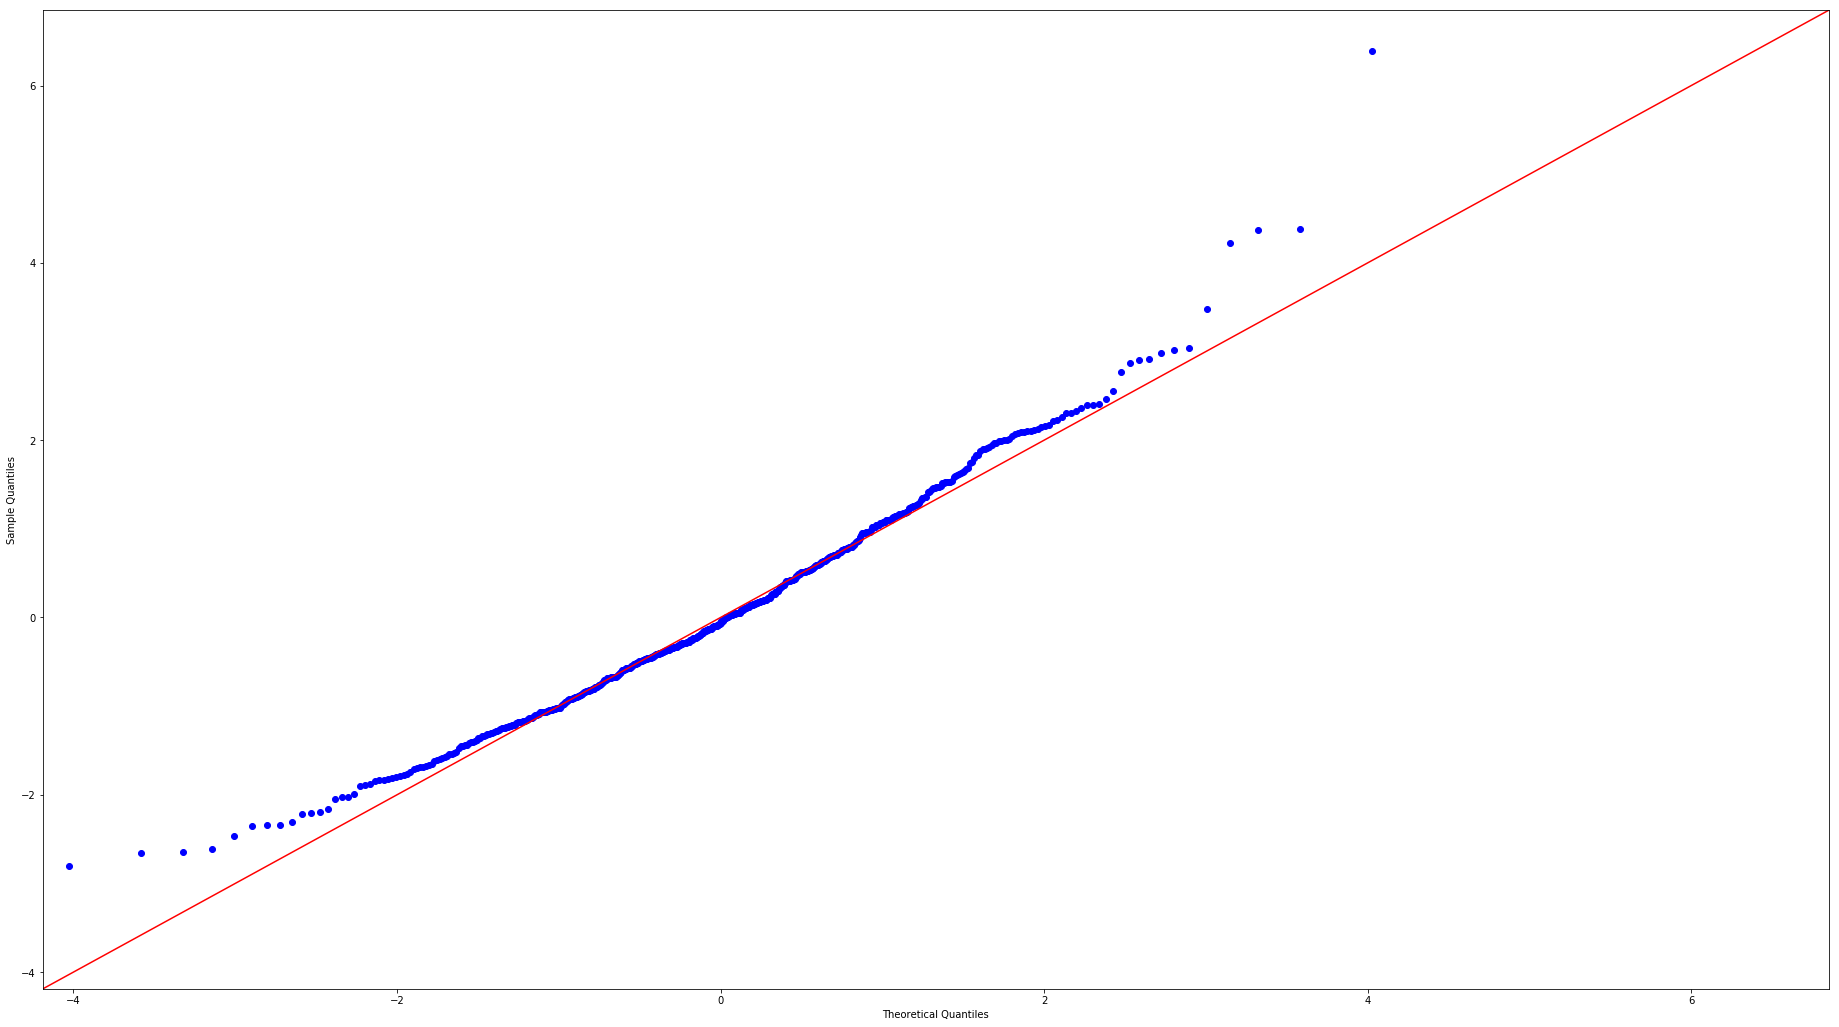

In [37]:
#qq-plotresults
sm.qqplot(weather_model.resid, stats.t, fit=True, line='45')
pylab.show()

In [38]:
vif = pd.DataFrame()
X = weather[["Mean_Temperature_F",'Precipitation_In']]
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,1.2,Mean_Temperature_F
1,1.2,Precipitation_In


In [39]:
weather_r_T_H_P = weather[['Mean_Temperature_F','Mean_Humidity', 'Precipitation_In', 'rides']].dropna()

In [40]:
weather_model = ols("rides ~ Mean_Temperature_F + Mean_Humidity + Precipitation_In - 1", data=weather_r_T_H_P).fit()
weather_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     4098.
Date:                Mon, 06 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:45:15   Log-Likelihood:                -4044.2
No. Observations:                 688   AIC:                             8094.
Df Residuals:                     685   BIC:                             8108.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Mean_Temperature_F     9.1693      0.187     48.974      0.000       8.802       9.537
Mean_Humidity         -2.3383      0.163    -14.351      0.000      -2.658      -2.018
Precipitation_In    -156.5684     15.090    -10.375      0.000    -186.197    -126.940
==============================================================================
Omnibus:                       63.824   Durbin-Watson:                   1.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.130
Skew:                           0.485   Prob(JB):                     2.29e-36
Kurtosis:                       5.187   Cond. No.                         408.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
X = weather[["Mean_Temperature_F",'Mean_Humidity', 'Precipitation_In']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(2)

,VIF Factor,features
0,10.64,Mean_Temperature_F
1,11.81,Mean_Humidity
2,1.39,Precipitation_In


In [42]:
weather_r_T_H_S_P = weather[['Mean_Temperature_F','Mean_Humidity','Max_Wind_Speed_MPH', 'Precipitation_In', 'rides']].dropna()

In [43]:
weather_model = ols("rides ~ Mean_Temperature_F + Mean_Humidity + Max_Wind_Speed_MPH + Precipitation_In - 1", data=weather_r_T_H_S_P).fit()
weather_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     3203.
Date:                Mon, 06 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:45:15   Log-Likelihood:                -4030.3
No. Observations:                 688   AIC:                             8069.
Df Residuals:                     684   BIC:                             8087.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Mean_Temperature_F     9.6035      0.201     47.792      0.000       9.209       9.998
Mean_Humidity         -1.9774      0.174    -11.391      0.000      -2.318      -1.637
Max_Wind_Speed_MPH    -4.7044      0.885     -5.318      0.000      -6.441      -2.968
Precipitation_In    -132.2139     15.491     -8.535      0.000    -162.629    -101.798
==============================================================================
Omnibus:                       71.031   Durbin-Watson:                   1.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.833
Skew:                           0.509   Prob(JB):                     1.49e-44
Kurtosis:                       5.450   Cond. No.                         430.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

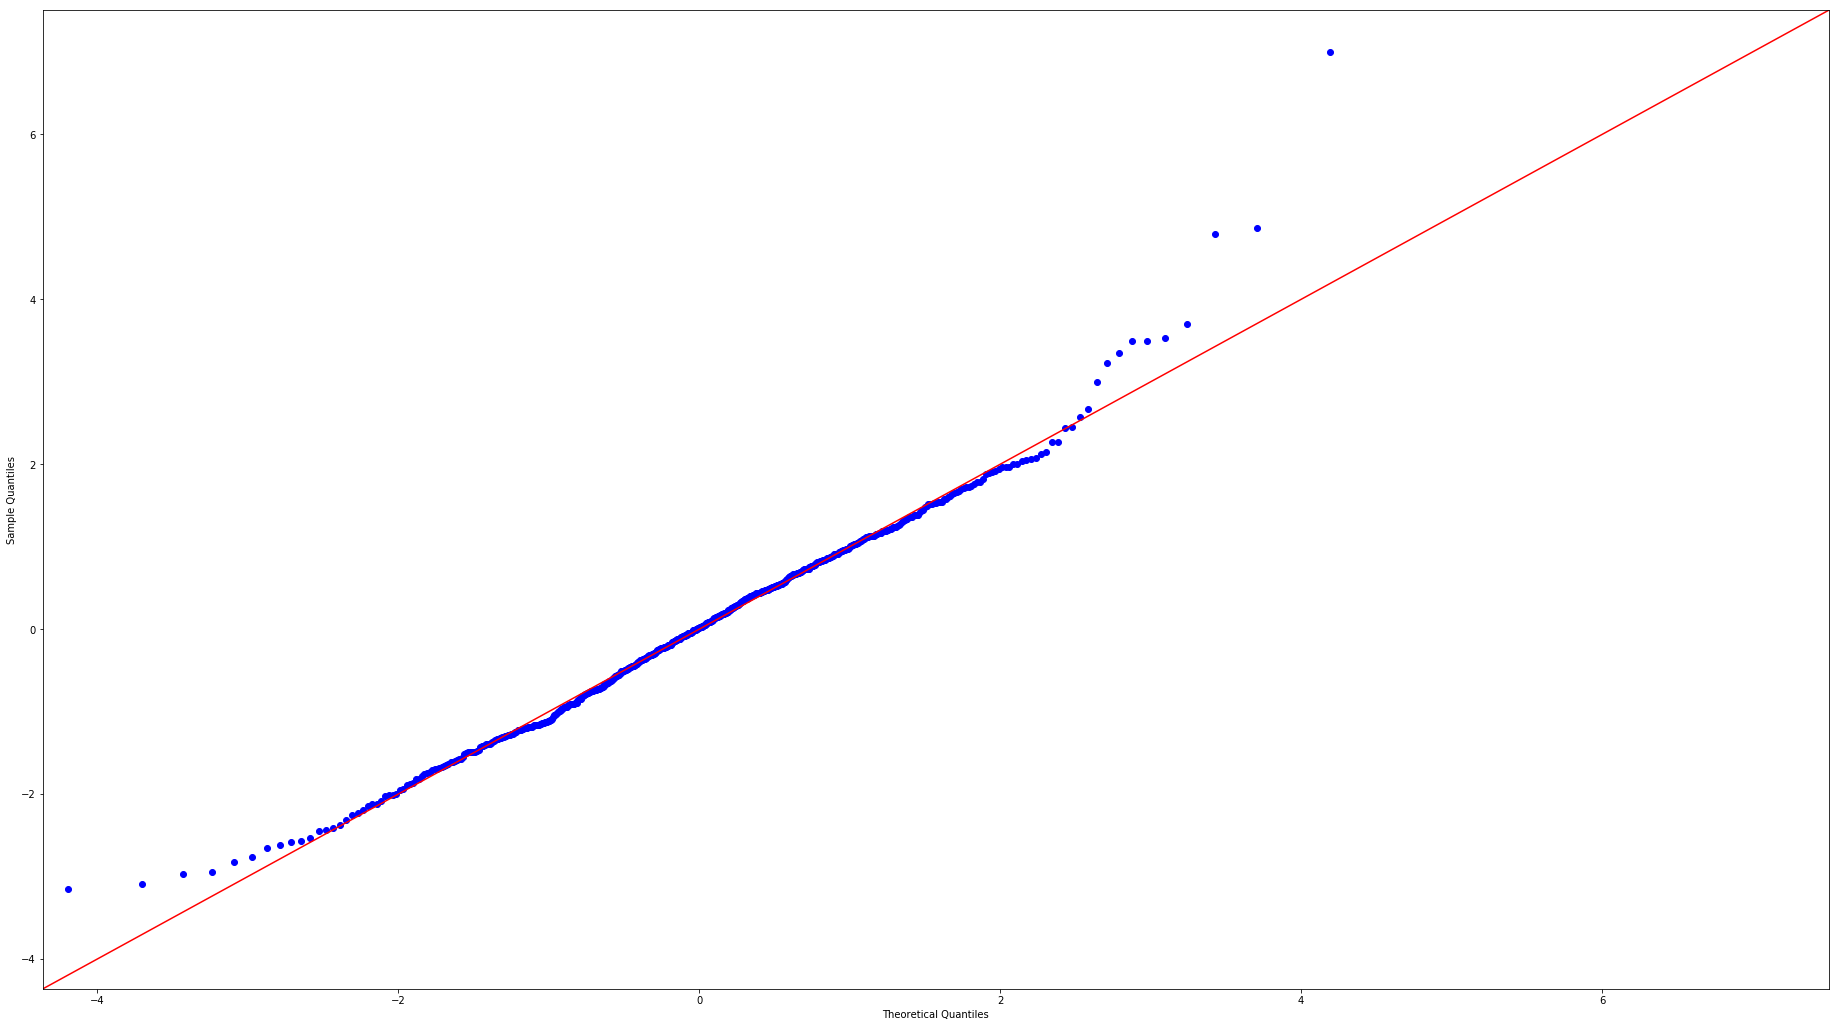

In [44]:
sm.qqplot(weather_model.resid, stats.t, fit=True, line='45')
pylab.show()

In [45]:
X = weather[["Mean_Temperature_F",'Mean_Humidity','Max_Wind_Speed_MPH', 'Precipitation_In']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,12.7,Mean_Temperature_F
1,13.9,Mean_Humidity
2,10.3,Max_Wind_Speed_MPH
3,1.5,Precipitation_In


In [46]:
# from sklearn import linear_model
X = weather[["Mean_Temperature_F",'Mean_Humidity','Max_Wind_Speed_MPH', 'Precipitation_In']]
y = weather[["rides"]]

# Fit the linear model
#model = linear_model.LinearRegression()
model = linear_model.Ridge()
results = model.fit(X, y)

# Print the coefficients
print (results.intercept_, results.coef_)

[ 150.3857693] [[   8.38775679   -3.0891169    -5.29584777 -112.74763146]]


In [47]:
print('Parameters:\n', weather_model.params)
print('R2: ', weather_model.rsquared)

Parameters:
 Mean_Temperature_F      9.603516
Mean_Humidity          -1.977442
Max_Wind_Speed_MPH     -4.704413
Precipitation_In     -132.213872
dtype: float64
R2:  0.949313130711


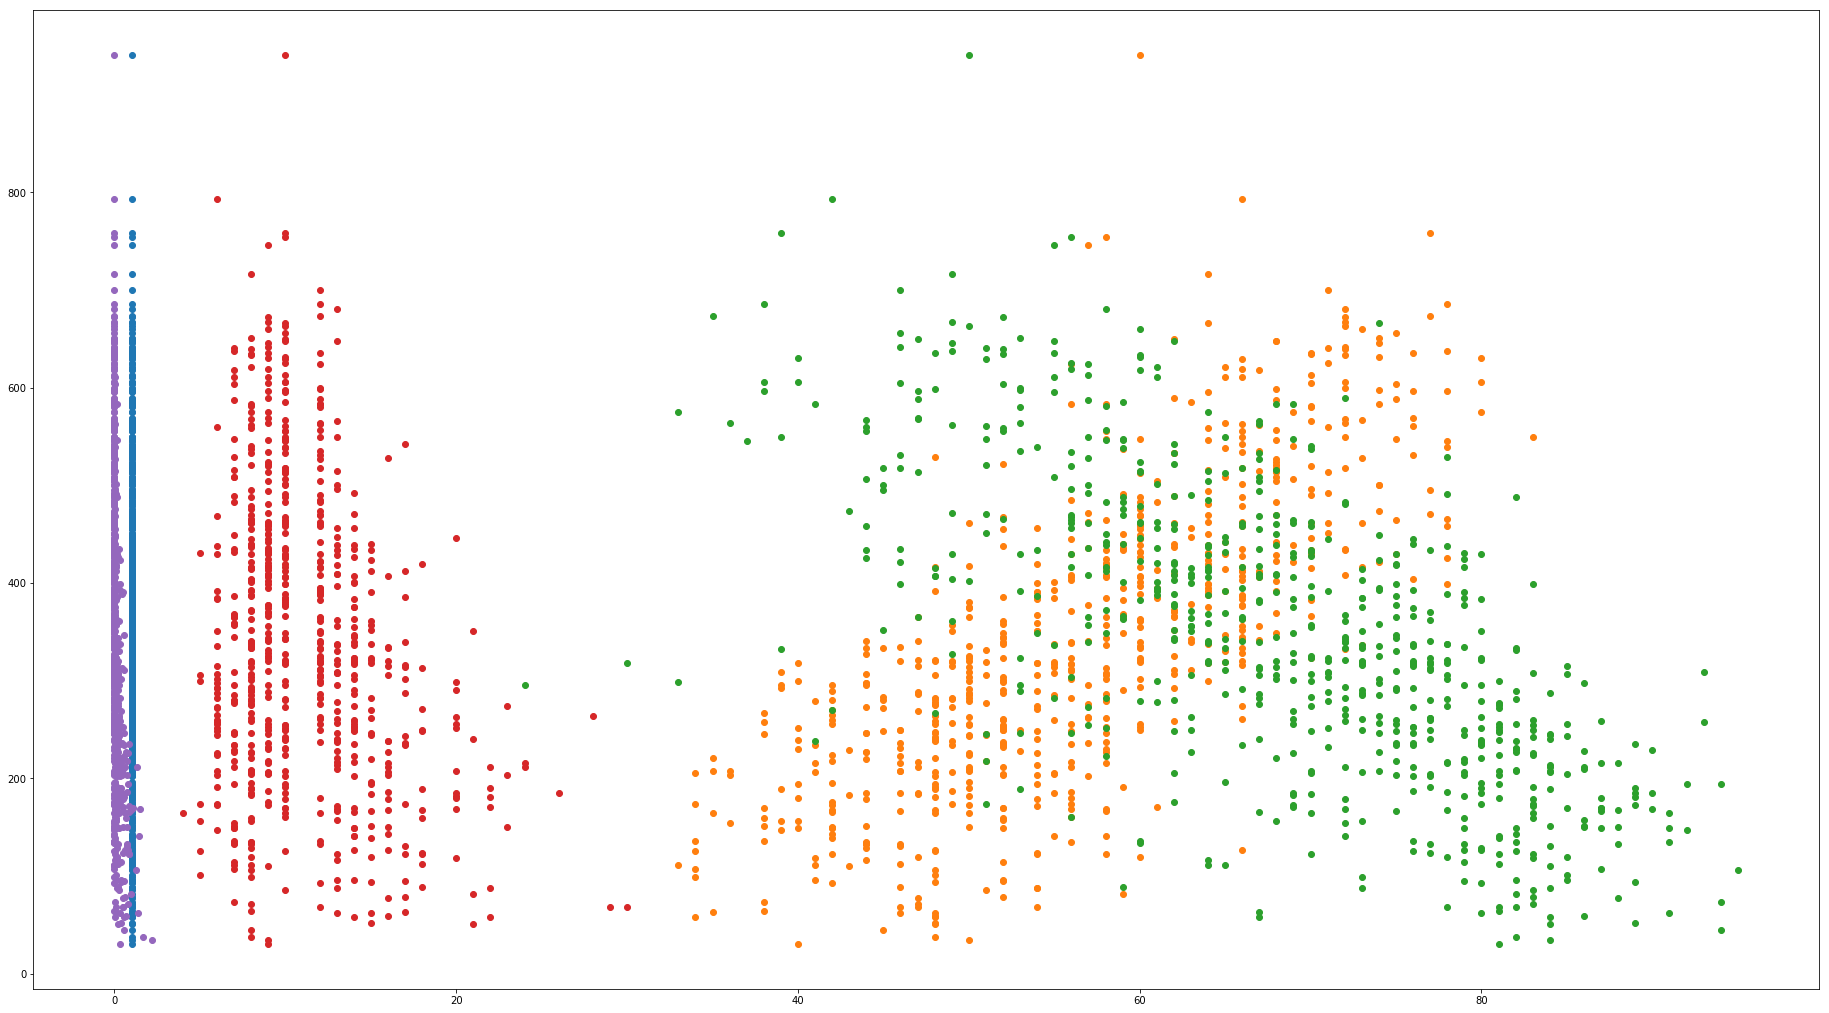

In [48]:
X = sm.add_constant(X) #  Our model needs an intercept so we add a column of 1s:
plt.plot(X, y, "o")
plt.show()